In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size
plt.rc("animation", html="html5")
import random

random.seed(10)
import numpy as np

np.random.seed(10)
from rich.jupyter import print

## Developing an agent for SCML2024 (OneShot)

In 2021, we introduced a new track called SCML-OneShot which implements a simplified problem in which the agent can focus on the many to many concurrent negotiation problem without needing to worry about long term planning or production planning as is the case with the standard and collusion tracks. 

**SCML-OneShot brief introduction** Please refer to the first tutorial for a [brief introduction](https://scml.readthedocs.io/en/latest/tutorials/01.run_scml2020.html) about the world simulated in this game as well as pointers to more information. We will assume knowledge of at least this brief introduction in the remainder of this tutorial.


First things first, let's create some helper functions that will allow us to evaluate different agents we develop in this tutorial:

In [2]:
from negmas import SAOResponse, ResponseType, Outcome, SAOState

from scml.oneshot.world import SCML2024OneShotWorld as W
from scml.oneshot import *
from scml.runner import WorldRunner
import pandas as pd
from rich.jupyter import print

In [3]:
# create a runner that encapsulates a number of configs to evaluate agents
# in the same conditions every time

CONFIGS, REPS, STEPS = 10, 3, 50
context = ANACOneShotContext(n_steps=STEPS, world_params=dict(construct_graphs=True))
single_agent_runner = WorldRunner(
    context, n_configs=CONFIGS, n_repetitions=REPS, save_worlds=True
)
full_market_runner = WorldRunner.from_runner(
    single_agent_runner, control_all_agents=True
)

Here we use the `WorldRunner` class which is designed to allow us to compare multiple agents in **exactly** the same conditions. To create a `WorldRunner`, you need to pass a context which is used for generating the worlds in which the agents are evaluated. the SCML package defines several contexts that allow us to control these worlds. For example the `StrongSupplierContext` will always create worlds in which the agent being evaluated is in the first production level $L_0$ with more agents on this level than on the next level. You cand define your own contexts for experimenting with specific conditions (e.g. specific exogenous contract distribution, market structure, etc). The most general context which will produce any world that your agent may encounter in the [ANAC comptition](https://scml.cs.brown.edu) is the `ANACOneShotContext` for one-shot worlds and `ANACStdContext` for standard worlds.

We create two runners:

1. **single_agent_runner** in which a single agent is being evaluated while the rest of the agents are sampled randomly from a subset of SCML built-in agents.
2. **full_market_runner** in which *all* agents in the market are controlled by the agent type being evaluated. This may be helpful in understanding how your agent behaves in this extreme condition but can be misleading as an estimate of the agent's performance in the official ANAC competition.

This is time to describe some of the tools that the `WorldRunner` gives you to evaluate the agent. The `WorldRunner` is a Callable. You just call it with the class (agent type) you want to evaluate. You can optionally pass parameters if you would like to compared different parameters for example. Remember in this case to also pass a name to differentiate between different parameter choices.

<div style="word-wrap: break-word; word-break: break-all; background-color:#98F1ED;">
<i>We are using a relatively large nubmer of configurations, repetitions per configuration and steps (days) per repetition. If you are running this notebook for the first time, consider reducing CONFIGS, REPS, STEPS above to make it run faster</i>.
   </div>

### Testing a completely random agent

Let's try an agent that behaves randomly:

In [4]:
full_market_runner(RandomOneShotAgent);

We can use the runner now to display the worlds for a given type that we evaluated:

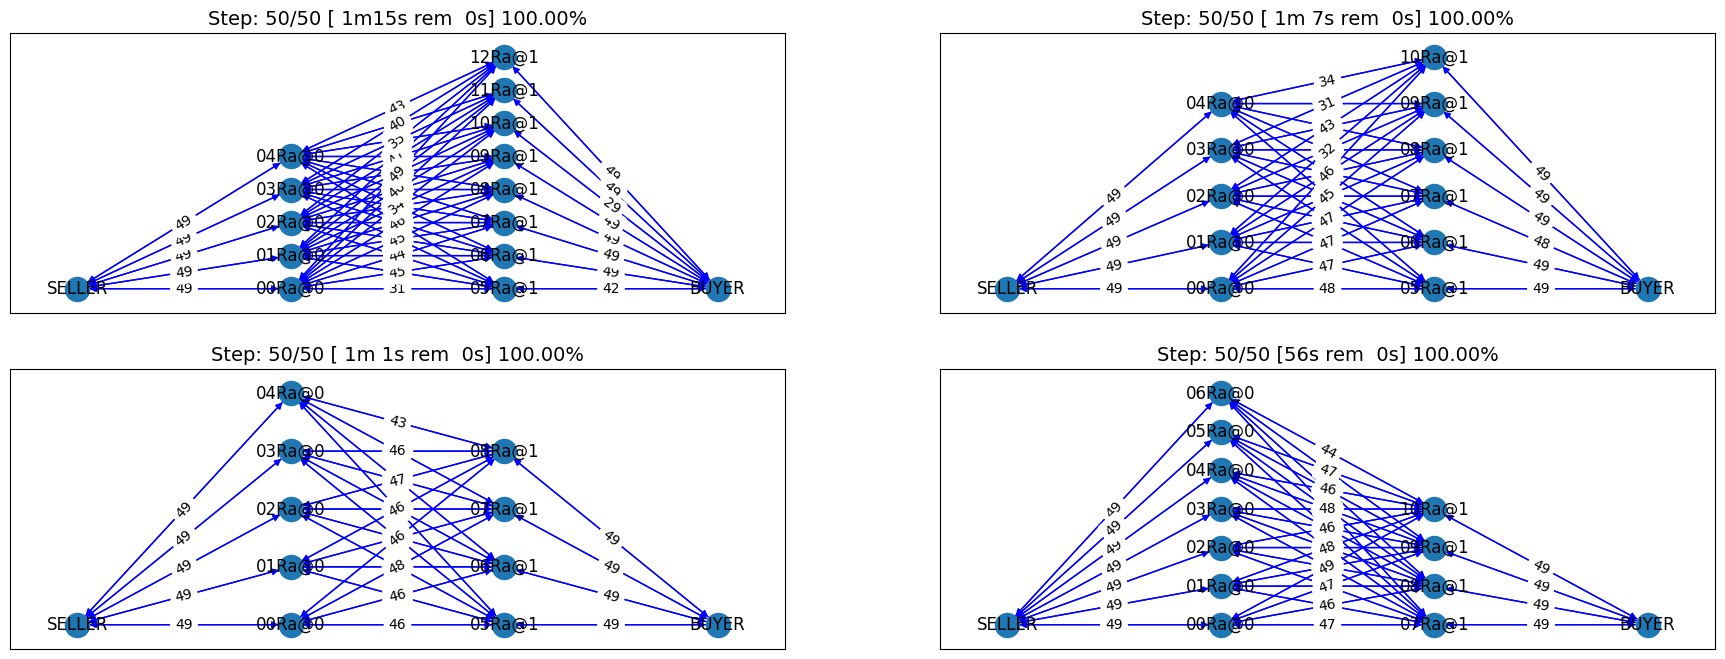

In [5]:
full_market_runner.draw_worlds_of(RandomOneShotAgent);

Lots of contracts have been reached, but were they good contracts?
We can use the runner now to plot several statistics (e.g. shortfall-penalty, disposal-cost, productivity, and score in this example). There are more than 42 such statistics that you can display.

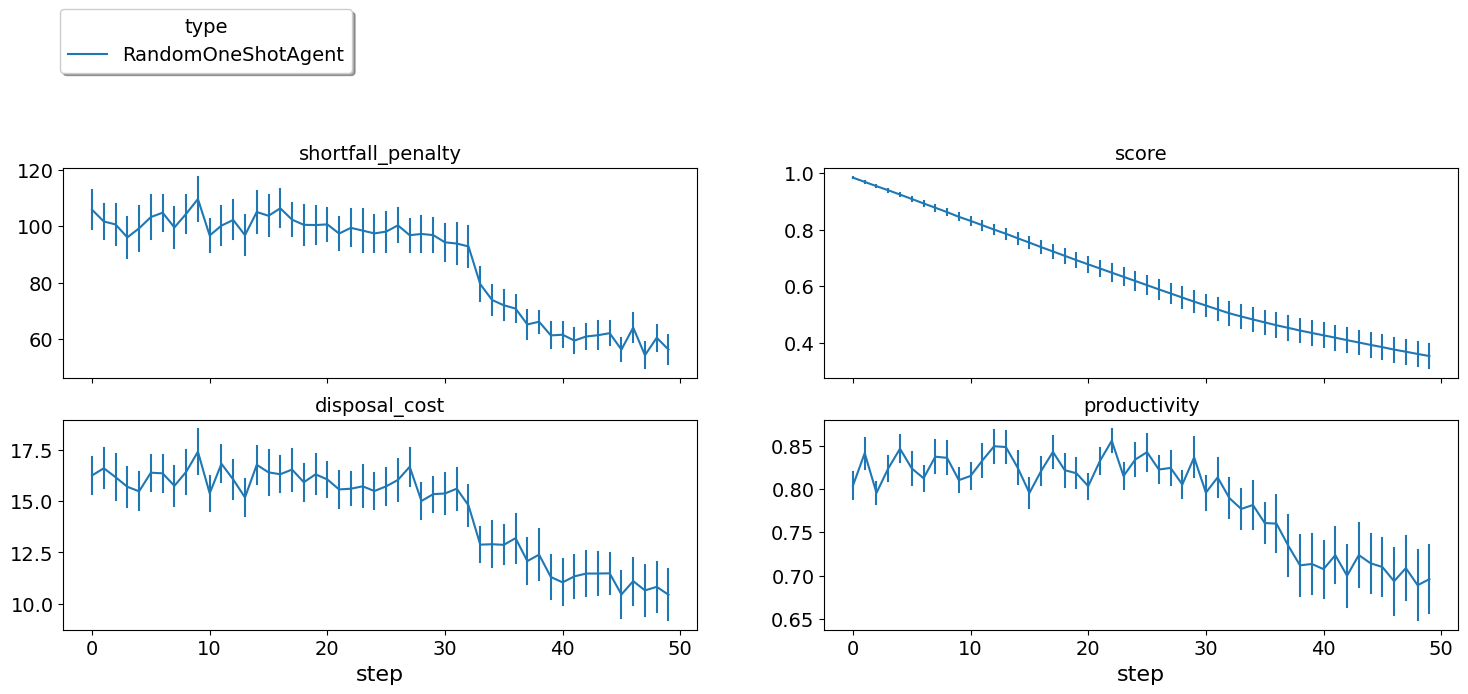

In [6]:
full_market_runner.plot_stats(agg=False);

The score is going down *monotonically* showing that this random agent is losing money every step.
Note that this test was when the agent controller *every* factory in the market. This is very different than the ANAC competition in whic the agent controls a single agent. Luckily, we already have a runner that tests exactly this case. Let's see how does `RandomOneShotAgent` behave in such cases:

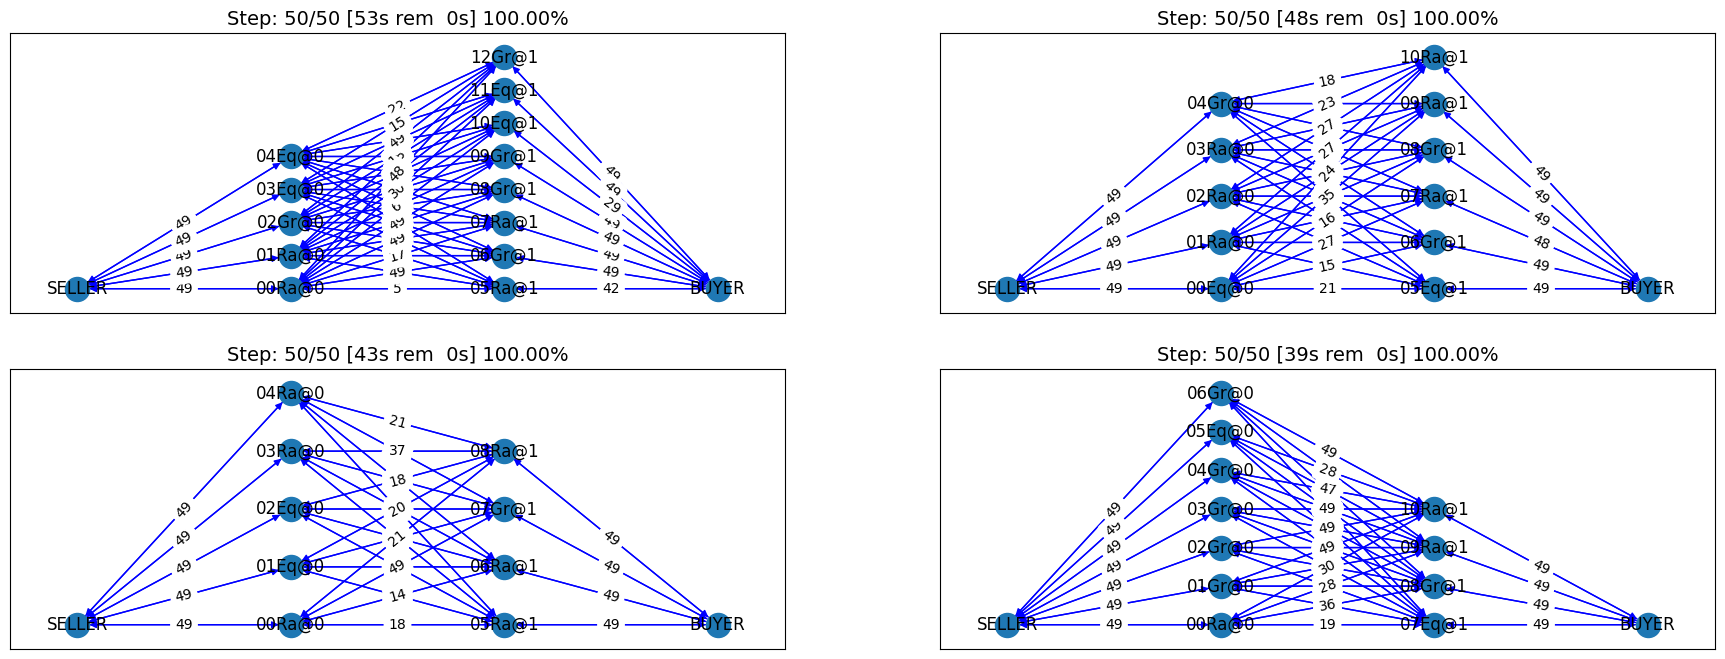

In [7]:
single_agent_runner(RandomOneShotAgent)
single_agent_runner.draw_worlds_of(RandomOneShotAgent);

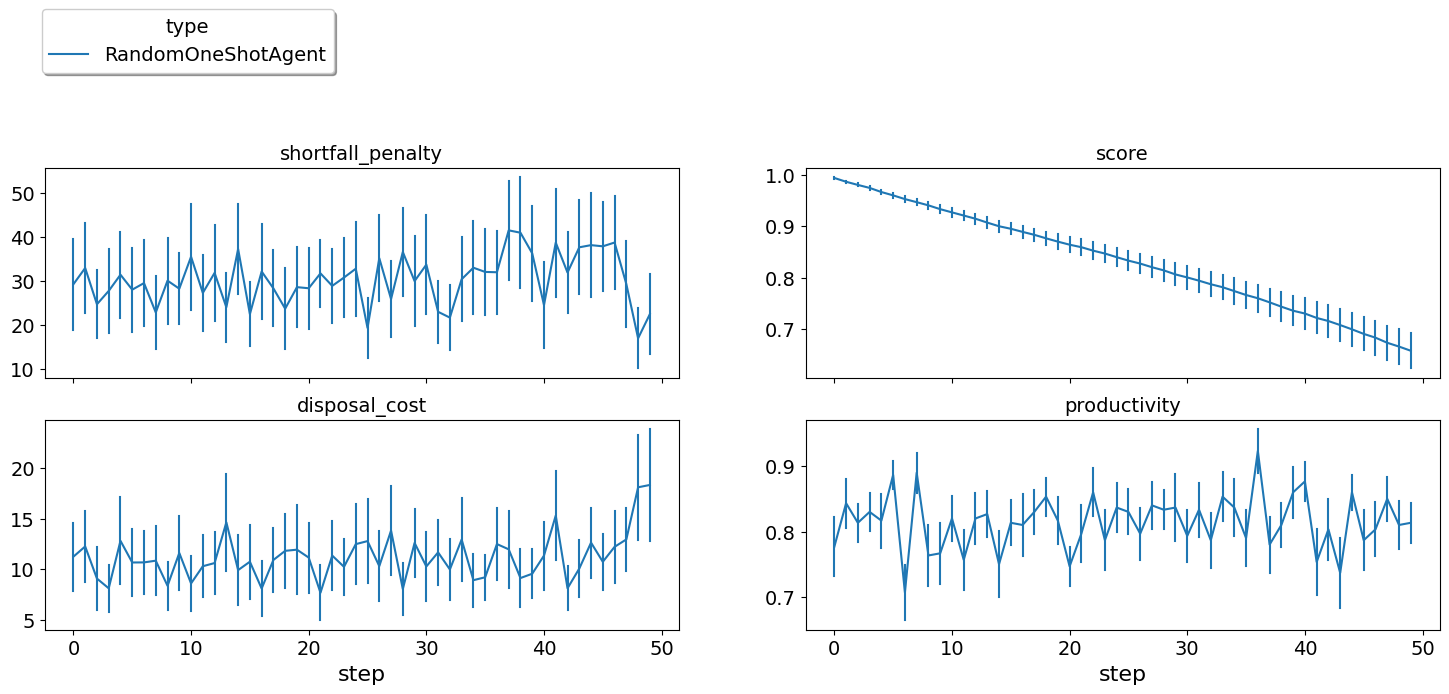

In [8]:
single_agent_runner.plot_stats(agg=False);

Still losing money but much less than before. The fact that other agents made sense actually help our random agent get higher score.
We can now check the distribution of scores for our agent using the `score_summary` method:

In [9]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
0,RandomOneShotAgent,0.65793,30.0,0.65793,0.185348,0.336662,0.517957,0.71734,0.780287,0.954094


You may have noticed that in some worlds multiple agents were of this random type (having Ra in their names). We can check which agent in each world was evaluated using the `agents_per_world_of` method:

In [10]:
single_agent_runner.agents_per_world_of(RandomOneShotAgent)

{'c0_RandomOneShotAgent_2/20240307H102843381773DM6bvVuL': [00Ra@0],
 'c1_RandomOneShotAgent_2/20240307H102843395130xCD2AEh6': [09Ra@1],
 'c2_RandomOneShotAgent_2/20240307H1028434068309wSk61hc': [03Ra@0],
 'c3_RandomOneShotAgent_2/20240307H1028434193944qJf2mRi': [10Ra@1],
 'c4_RandomOneShotAgent_2/20240307H1028434348725FI408iN': [02Ra@0],
 'c5_RandomOneShotAgent_2/20240307H102843446517qRCJQARL': [06Ra@1],
 'c6_RandomOneShotAgent_2/20240307H1028434575457oq3tBfI': [07Ra@1],
 'c7_RandomOneShotAgent_2/20240307H1028434712435BW7DlOy': [10Ra@1],
 'c8_RandomOneShotAgent_2/20240307H1028434854184xqGXFax': [12Ra@1],
 'c9_RandomOneShotAgent_2/20240307H102843497378K9hijmDw': [09Ra@1]}

This random agent always loses money. Can we do better?
Let's start by an agent that does absolutely nothing.

### An agent that does nothing

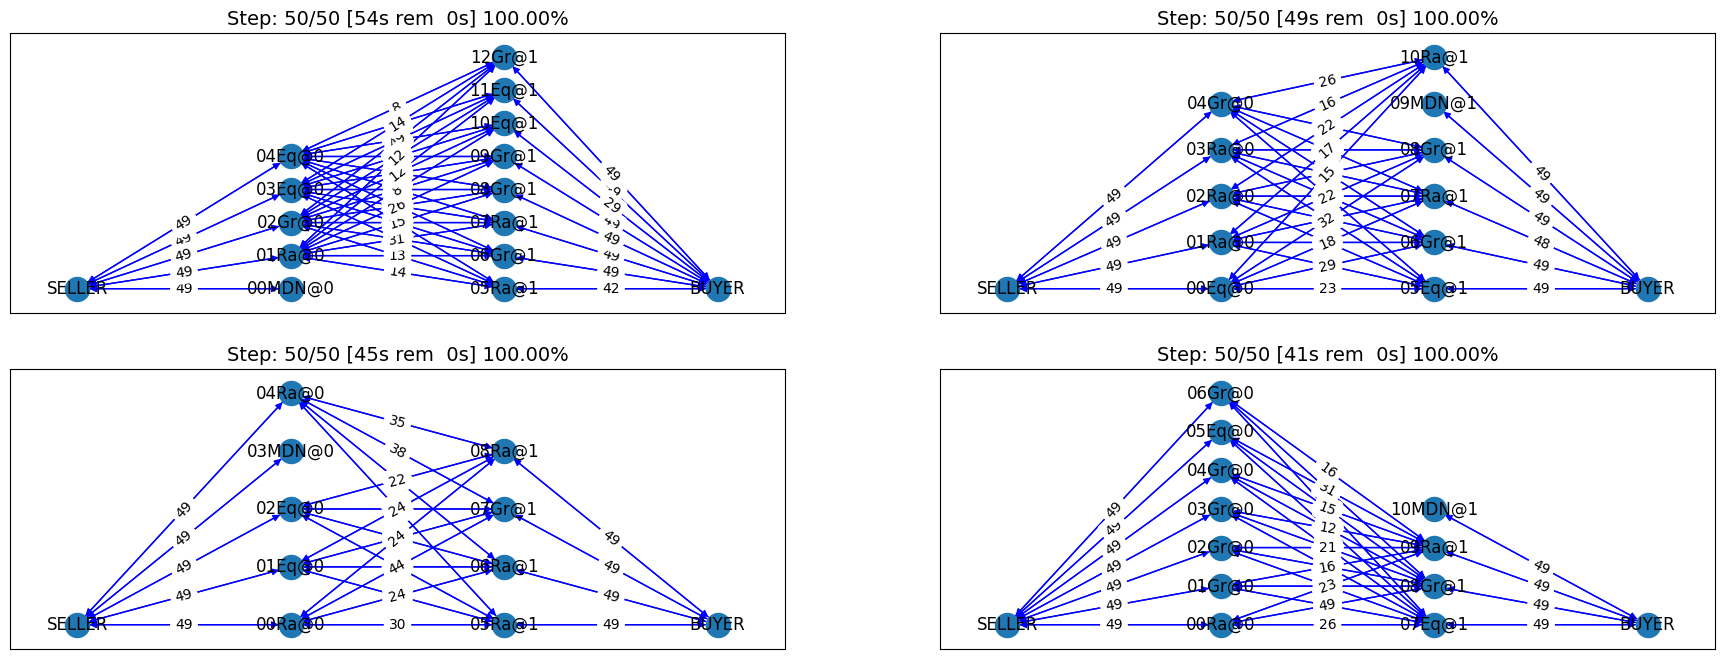

In [11]:
class MyOneShotDoNothing(OneShotPolicy):
    """My Agent that does nothing"""

    def act(self, state):
        return {}


""
single_agent_runner(MyOneShotDoNothing)
single_agent_runner.draw_worlds_of(MyOneShotDoNothing);

In all of the graph representing world simulations, we use short names that represent the type of the agent. For example an agent named `03Ran@1` is an agent of type `RandomOneShotAgent` at production level 1 that was the third agent to create. `MDN` here is a shorthand for `MyOneShotDoNothingAgent` (we will usually remove `OneShot` and `Agent` from the name before shortening it).

Notice how there is exactly one agent of our type (MDN) in each simulation. Moreover, these are in exactly the same palces in which the random agents evaluated were before. This is how we can guarantee that the comparison is fair.

Looking at the `contracts-signed`, we can see that none of the concluded contracts involved our do-nothing agent. Nevertheless, these agents still had *exogenous contracts* which means that they will lose money. A do-nothing agent will usually lose money in this game.

Let's check the scores of different agents to confirm:

In [12]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
0,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
1,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094


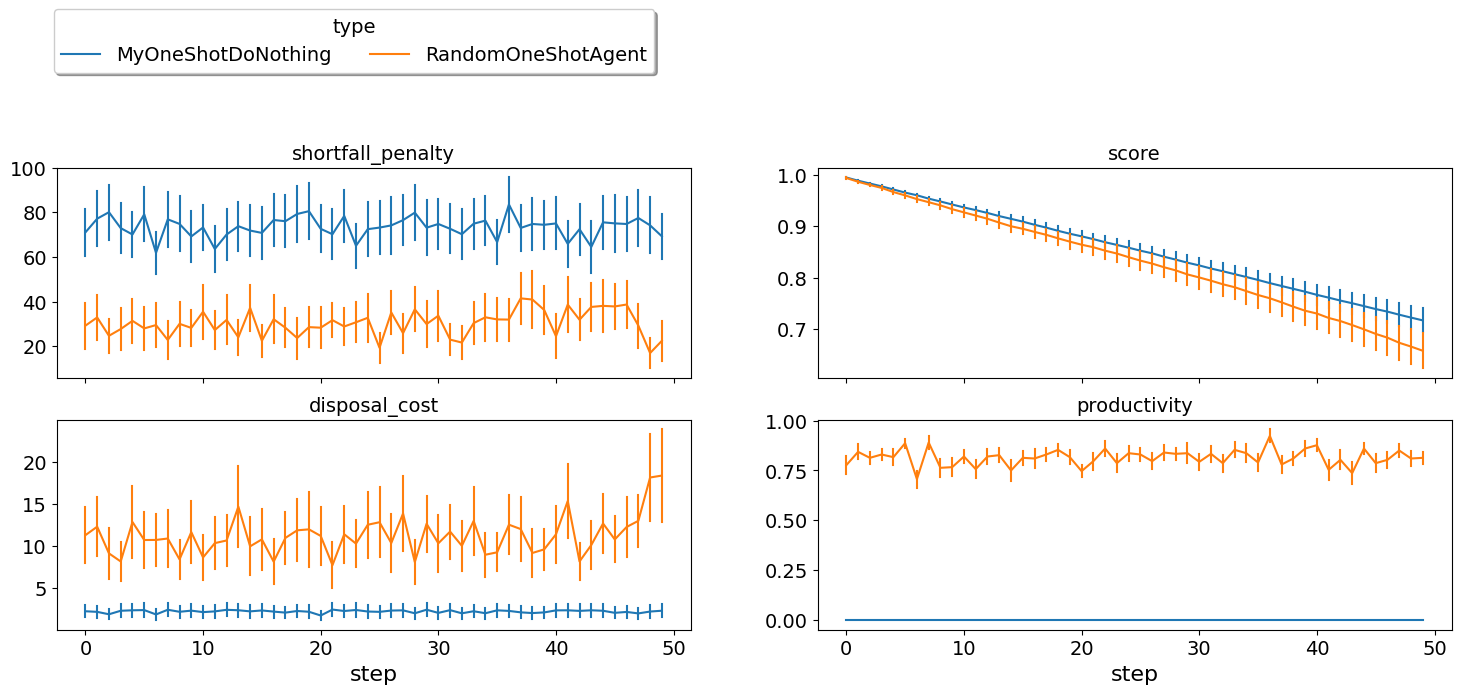

In [13]:
single_agent_runner.plot_stats(agg=False);

It is clear that our do-nothing agent always loses money and is even worse than acting randomly. That is because it cannot get any contracts from negotiation to satisfy its needs from the exogenous contracts but it still has to pay for disposal cost and shortfall penalty. This is by design. We set the penalties so that this is almost always the case to encourage agents to trade. 

We can also have a look at the *exogenous* contracts that drive the market.

In [14]:
import math
from typing import Iterable


def analyze_contracts(worlds, exogenous_only=True):
    """
    Analyzes the contracts signed in the given world
    """
    dfs = []
    for world in worlds:
        dfs.append(pd.DataFrame.from_records(world.saved_contracts))
    data = pd.concat(dfs)
    if exogenous_only:
        data = data.loc[
            (data["seller_name"] == "SELLER") | (data["buyer_name"] == "BUYER"), :
        ]
    return data.groupby(["seller_name", "buyer_name"])[["quantity", "unit_price"]].agg(
        dict(quantity=("sum", "count"), unit_price="mean")
    )


analyze_contracts(single_agent_runner.worlds_of())

quantity       unit_price
                            sum count       mean
seller_name buyer_name                          
04Eq@1      BUYER          2442   300  28.000000
05Eq@1      BUYER          5406   600  27.550000
05Ra@1      BUYER          4344   852  26.542254
06Eq@1      BUYER          2106   300  29.160000
06Gr@1      BUYER          6834   900  27.133333
06MDN@1     BUYER          1371   150  28.200000
06Ra@1      BUYER          6375   750  28.240000
07Eq@1      BUYER          2742   300  27.460000
07Gr@1      BUYER         13638  1500  27.752000
07MDN@1     BUYER           774   150  27.860000
07Ra@1      BUYER          3630   744  27.229839
08Eq@1      BUYER          5460   600  27.780000
08Gr@1      BUYER          8766  1200  27.085000
08Ra@1      BUYER         10638  1200  28.075000
09Gr@1      BUYER          4668   888  28.250000
09MDN@1     BUYER          2382   300  26.990000
09Ra@1      BUYER          9996  1200  27.562500
10Eq@1      BUYER          2910   480  27.412500
10Gr@1      BUYER          3054   546  28.241758
10MDN@1     BUYER          2817   300  27.930000
10Ra@1      BUYER          4341   600  27.715000
11Eq@1      BUYER          4182   600  27.690000
11Gr@1      BUYER          2178   300  29.160000
11Ra@1      BUYER          1890   300  29.440000
12Gr@1      BUYER          4320   600  27.930000
12MDN@1     BUYER          1143   150  28.480000
12Ra@1      BUYER          4023   450  28.360000
13Ra@1      BUYER          4824   600  29.290000
SELLER      00Eq@0         9894  1200   9.940000
            00Gr@0         2658   300  10.260000
            00MDN@0        1338   150  10.100000
            00Ra@0        12636  1350   9.940000
            01Eq@0         5304   600   9.930000
            01Gr@0         8532   900   9.893333
            01Ra@0        13176  1500  10.064000
            02Eq@0        11064  1200  10.035000
            02Gr@0         7554   900   9.893333
            02MDN@0        1317   150  10.020000
            02Ra@0         7059   750  10.108000
            03Eq@0         7608   900  10.013333
            03Gr@0         8688   900  10.133333
            03MDN@0        1446   150  10.220000
            03Ra@0         9660  1050  10.145714
            04Eq@0        10392  1200   9.985000
            04Gr@0        10854  1200   9.960000
            04Ra@0         2352   300   9.840000
            05Eq@0         5448   600   9.850000
            05Gr@0         8400   900   9.986667
            06Eq@0         2904   300   9.720000
            06Gr@0         2400   300  10.340000
            06Ra@0         2898   300  10.120000
            07Ra@0         2760   300  10.160000

There are few things to note about the distribution of the *exogenous* contracts:

- The unit price of the raw material is always lower than that of the final product. This is the source of profitability in this market.
- Each agent has a different mean and standar deviation for the quantities in its exogenous contracts. This means that different agents will have different utility functions but these utility functions for different steps are related because the exogenous contract is sampled from some common distribution for each agent for all the steps which makes learning more useful in the game.

### Building your own agent


A one-shot agent needs only to do negotiation. The simplest possible version (`MyDoNothingAgent` above) just responded to offers from its partners and proposed new offers to them. 

Looking at the graph for the world simulation, we can see immediately some features of the one-shot simulation that are not replicated in the full SCML game:

- All negotiation requests are accepted. In fact in the one-shot game, the agent need not consider requesting negotiations or deciding the negotiation agenda as the system takes care of this ensuring that on every simulated day every agent is negotiating with its suppliers and or consumers about trade on that day (and only that day).
- Contracts in the one-shot game are always executed (despite not showing that in the graph). There is no concept of a breach. Failure to honor contracts is instead penalized monetarily. Contracts are also never cancelled or nullified. This greatly simplifies the problem as the agent does not need to keep track of contract execution.
- Production is too fast that it does not affect the agent reasoning. In the terminology to be presented in the following tutorial, there is no need for an explicit production strategy.
- There is no need to consider future negotiations while reasoning about a the current set of negotiations. This greatly simplifies agent design as there is no long-term planning. In the terminology to be presented in the following section, there is no need for a trading strategy


#### Your AWI

As described in the [previous tutorial](https://scml.readthedocs.io/en/latest/tutorials/01.run_scml2020.html), your agent can sense and act in the simulation by accessing methods and properties of its AWI which is accessible at any time as:

```python
self.awi
```

You can see all of these methods and properties specific for the **OneShotAWI** and its descendents [here](https://scml.readthedocs.io/en/latest/api/scml.oneshot.OneShotAWI.html).

#### Your ufun

The Oneshot game has the advantage that it is possible at the end of each simulation step (day) to calculate **exactly** the profit you will be getting for the set of contracts you have (either through negotiation or as exogenous contracts). We provide a utility function class ([OneShotUtilityFunction](https://scml.readthedocs.io/en/latest/api/scml.oneshot.OneShotUFun.html) which can be used normally as any NegMAS [UtilityFunction](http://www.yasserm.com/negmas/api/negmas.preferences.UtilityFunction.html). This ufun is available to your all the time (a new one is created for each simulation step) and is accessible as:

```python
self.ufun
```

The most important services this ufun class provides for you are the following:

- `from_offers`: This method receives a list of outcomes and a list of booleans indicating whether each of them is for buying or for selling. It returns to you the profit you will get if all of these outcomes *and nothing else* became contracts. An outcome is just a tuple  (quantity, delivery time, unit price). You can use this callback during negotiation to judge hypothetical agreements with your partners. 
- `from_contracts`: This method is the same as `from_offers` but it receives a list of `Contract` objects. It is useful after all negotiations are finished to calculate the profit you will be getting for this step.
- `is_breach`: will tell you whether or not getting the given total input and output quantities will make you cause a breach. Notice that breaches are expected in the OneShot track as any mismatch in the quantities of inputs and outputs will constitute a breach.
- `breach_level`: returns a value between zero and one specifying the level of breach that will be recorded for a given total input and output quantities.
- `find_limit`: finds either the maximum or the minimum possible profit (minimum profit is maximm loss) attainable in the current simulation step (day). This is useful when you want to normalize utility values between zero and one. Two of the agents we will develop during this tutorial will use this feature.
- `max_utility`, `min_utility`: give the maximum and minimum utilities/profits attainable. Note that you must prepare them by calling `find_limit`. We will go into how to do that later.
- `best`, `worst`: give more information about the cases of maximum and minimum profit (i.e. the total input and output quantity needed, the prodcible quantity, best possible prices for buying and selling, etc). Again, these are not available except after calling `find_limit`.


#### Your callbacks

Your agent needs to implement methods that are called by the system at various time during the negotiation. You can find a full list in the [game description](https://yasserfarouk.github.io/files/scml/y2024/scml2024oneshot.pdf).

The most important ones are:

- `init()` called once at the beginning of the simulation (i.e. before the first day starts). At this point, your AWI is set but you should not assume anything else.
- `before_step()` called at the **beginning** of *every day*. At this point, your `ufun` is set and market information is available.
- `step()` called at the **end** of *every day*. You can use this to analyze what happened during the day and modify your strategy in the future.
- `on_negotiation_success()`/`on_negotiation_failure()` called after each negotiation is concluded to let you know what happened in it.
- Depending on your base-class, you will also need to implement methods that allow you to control negotiations. These will be explained in details in the following sections but here is a summary:
   - **OneShotAgent** If your agent is based on `OneShotAgent`, you will get a `propose()` call when you need to offer something to one of our partners during negotiation and `respond()` when asked to respond to one of its offers.
   - **OneShotSyncAgent** If your agent is based on `OneShotSyncAgent` you will get a call to `first_proposals()` once every day to set your first proposal in all negotiations and a `counter_all()` call to counter offers from your partners. The system will try to always give you one offer from each partner in the `counter_all()` call but that is not guaranteed and sometimes it may be called with a subset of the offers.
   - **OneShotPolicy** This is very similar to `OneShotSyncAgent` with only one callback `act()` which receives the AWI (as `state`) and returns a mapping from each partner to an `SAOResponse` (i.e. acceptance, ending negotiation, or rejection and a counter offer). This is mostly there to help build RL agents (see next tutorial).
   - **OneShotSingleAgreementAgent** If your agent is based on `OneShotSingleAgreementAgent` you will have to implement `is_acceptable()` to decide if a given offer is acceptable to you, `best_offer()` to find the *best* offer in a given negotiation for your agent and `is_better()` to compare two offers. Once you implement these, the agent will implement all callback for you trying to get **a single** agreement that maximizes your utility. Note that, again, it is not guaranteed that you will get a single agreement at the end but the system will try its best to achieve that.

Now we can start working on our agent.

We will discuss these different base classes and basing your agent in each of them in more details in what follows.

### OneShotAgent

This is the base class of all agents for SCML-OneShot. Both `SyncOneShotAgent` and `SingleAgreementOneShotAgent` inherit from this class and provide support for a simplified way of developing your agent (or so we think). It is perfectly OK to use `OneShotAgent` directly as the base of your agent.

As discussed earlier, you will receive a `propose` and `respond` call for each round in each negotiation. The `propose` method receives the negotiation state (an object of the type [`SAOState`](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOState.html) including among other things the current negotiation step, relative time, last offer, etc) and is required to return an `Outcome` which is just a tuple of a quantity, delivery time (must be this simulation step) and unit price, in that order (See [`negmas` documentation](https://negmas.readthedocs.io/en/latest)) as an offer. The `respond` method receives a negotiation state and an offer (`Outcome`) from the opponent and needs to respond to it by a decision from the [`ResponseType` enumeration](https://negmas.readthedocs.io/en/latest/api/negmas.gb.ResponseType.html) (`REJECT_OFFER`, `ACCEPT_OFFER`, and `END_NEGOTIATION`). Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `before_step`/`step` call before/after each simulation step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these seven callbacks. All of these callbacks except `propose` and `respond` are optional.

#### Simple OneShotAgent 
We have already seen how to develop a do-nothing agent using the `OneShotAgent` class. Let's try to develop some more meaningful agent using the same base class.

In [15]:
class SimpleAgent(OneShotAgent):
    """A greedy agent based on OneShotAgent"""

    def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)

    def respond(self, negotiator_id, state, source=""):
        offer = state.current_offer
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return ResponseType.END_NEGOTIATION
        return (
            ResponseType.ACCEPT_OFFER
            if offer[QUANTITY] <= my_needs
            else ResponseType.REJECT_OFFER
        )

    def best_offer(self, negotiator_id):
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return None
        ami = self.get_nmi(negotiator_id)
        if not ami:
            return None
        quantity_issue = ami.issues[QUANTITY]

        offer = [-1] * 3
        offer[QUANTITY] = max(
            min(my_needs, quantity_issue.max_value), quantity_issue.min_value
        )
        offer[TIME] = self.awi.current_step
        offer[UNIT_PRICE] = self._find_good_price(ami)
        return tuple(offer)

    def _find_good_price(self, ami):
        """Finds a good-enough price."""
        unit_price_issue = ami.issues[UNIT_PRICE]
        if self._is_selling(ami):
            return unit_price_issue.max_value
        return unit_price_issue.min_value

    def is_seller(self, negotiator_id):
        return negotiator_id in self.awi.current_negotiation_details["sell"].keys()

    def _needed(self, negotiator_id=None):
        return (
            self.awi.needed_sales
            if self.is_seller(negotiator_id)
            else self.awi.needed_supplies
        )

    def _is_selling(self, ami):
        return ami.annotation["product"] == self.awi.my_output_product

Let's see how well did this agent behave:

In [16]:
single_agent_runner(SimpleAgent)
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
2,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
0,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
1,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094


we can check how the score and other statistics of this type of agent changes over time:

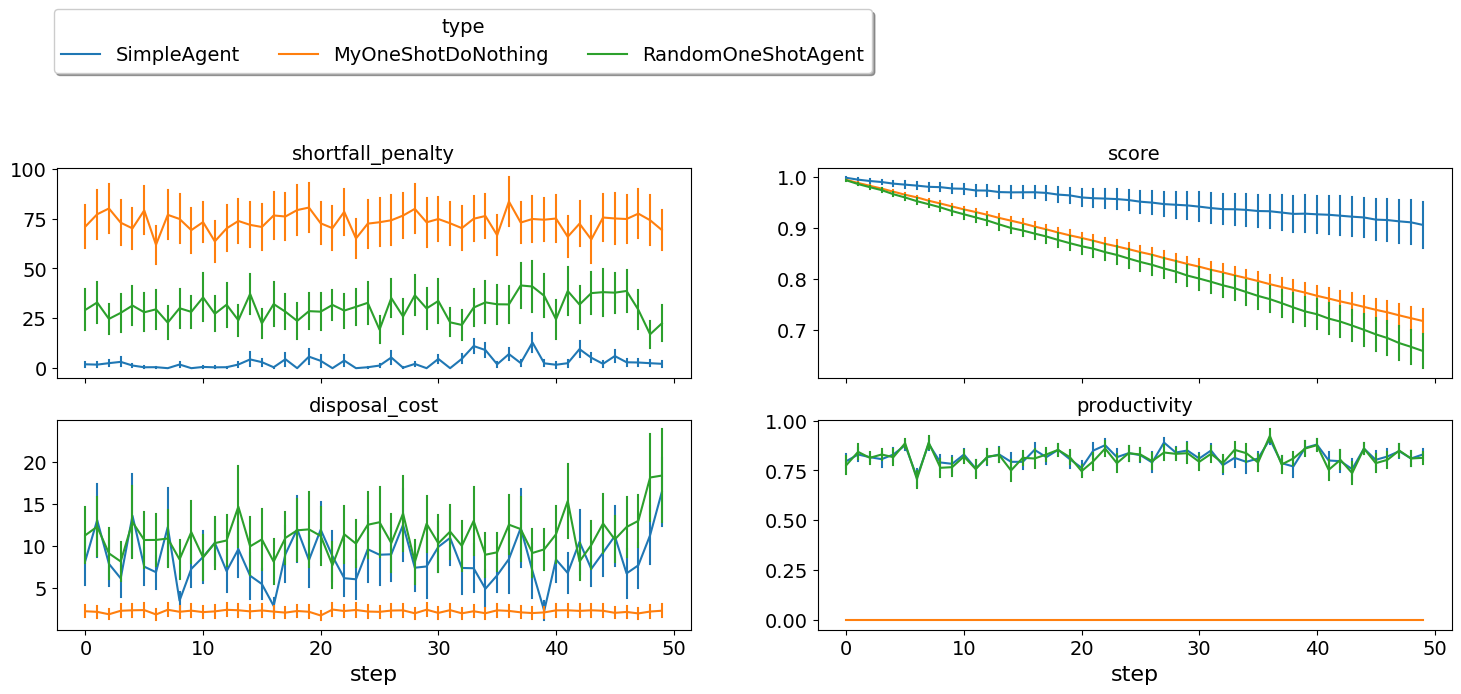

In [17]:
single_agent_runner.plot_stats(agg=False);

This simple agent is better than the random agent and our do-nothing agent. It can make around 1% profit. Let's understand how it works:

The main idea of this agent is pretty simple. It tries to *secure* as much of its needs (sales/supplies) as possible in every negotiation at the best possible price for itself.

To achieve this goal, the agent uses the fact that the `AWI` already keeps track of this information as `needed_supplies` and `needed_sales`.
Therefore, it defines a helper that calculates the amount it needs by subtracting the exogenous quantity it has from the amount it secured

```python
def _needed(self):
    self.awi.needed_sales if self.is_seller(negotiator_id) else self.awi.needed_supplies
```

where it uses `needed_sales` if the current negotiation is for selling and `needed_supplies` otherwise. Now that the agent can calculate how much it needs to buy/sell, it implements the negotiation related call-backs (`propose` and `respond`). 

Here is the full implementation of `propose`:
```python
def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)
```

The agent is always offering its best offer which is calculated in the `best_offer` method to be discussed later. It does not conceed at all.

Responding to opponent offers is also simple:

- it starts by calculating its needs using the helper `_needed`, and ends the negotiation if it needs no more sales/supplies
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return ResponseType.END_NEGOTIATION
```
- If the offered quantity is less than its needs, accept the offer. Otherwise reject the offer.
```python
    return ResponseType.ACCEPT_OFFER if offer[QUANTITY] <= my_needs else ResponseType.REJECT_OFFER
```

Most of the code is in the `best_offer` method which calculates the best offer for a negotiation *given the agreements reached so far*. Let's check it line by line:

- The agent checks its needs and returns `None` ending the negotiation if it needs no more sales/supplies. We also get access to the AMI.
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return None
    ami = self.get_nmi(negotiator_id)
    if not ami:
        return None
```

- It then finds out the `Issue` objects corresponding to the quantity and unit-price for this negotiation and initializes an offer (we have 3 issues)
```python
    quantity_issue = ami.issues[QUANTITY]
    unit_price_issue = ami.issues[UNIT_PRICE]
    offer = [-1] * 3
```
- The time is always the current step. 
```python    
    offer[TIME] = self.awi.current_step
```
- The quantity to offer is simply the needs of the agent without mapped within the range of the quantities in the negotiation agenda (note that this may lead the agent to buy more than its needs). 
```python    
    offer[QUANTITY] = max(
        min(my_needs, quantity_issue.max_value), quantity_issue.min_value
    )
```
- Finally, the unit price is the maximum possible unit price if the agent is selling otherwise it is the minimum possible price. Note that `is_selling()` assumes that the agent will never find itself in a middle layer in a deep negotiation. We will alleviate this issue later. 
```python
    if self._is_selling(ami):
        offer[UNIT_PRICE] = unit_price_issue.max_value
    else:
        offer[UNIT_PRICE] = unit_price_issue.min_value
    return tuple(offer)
```

### A (suposedly) better greedy agent

One problem with our `SimpleAgent` is that it does not take price into account in two ways:

- When asked to `propose`, it *always* proposes an offer with the best price for itself. It **never concedes** on prices. In many cases this will lead to disagreement.
- When asked to `respond` to an offer, *it does not even check the price*. This may lead to bad agreements (i.e. very high buying prices/very low selling prices).

We will try to remedie both of these issues in the following agent:

In [18]:
class BetterAgent(SimpleAgent):
    """A greedy agent based on OneShotAgent with more sane strategy"""

    def __init__(self, *args, concession_exponent=0.2, **kwargs):
        super().__init__(*args, **kwargs)
        self._e = concession_exponent

    def respond(self, negotiator_id, state, source=""):
        offer = state.current_offer
        if offer is None:
            return ResponseType.REJECT_OFFER
        response = super().respond(negotiator_id, state, source)
        if response != ResponseType.ACCEPT_OFFER:
            return response
        nmi = self.get_nmi(negotiator_id)
        return (
            response
            if self._is_good_price(nmi, state, offer[UNIT_PRICE])
            else ResponseType.REJECT_OFFER
        )

    def _is_good_price(self, nmi, state, price):
        """Checks if a given price is good enough at this stage"""
        mn, mx = self._price_range(nmi)
        th = self._th(state.step, nmi.n_steps)
        # a good price is one better than the threshold
        if self._is_selling(nmi):
            return (price - mn) >= th * (mx - mn)
        else:
            return (mx - price) >= th * (mx - mn)

    def _find_good_price(self, nmi):
        """Finds a good-enough price conceding linearly over time"""
        state = nmi.state
        mn, mx = self._price_range(nmi)
        th = self._th(state.step, nmi.n_steps)
        # offer a price that is around th of your best possible price
        if self._is_selling(nmi):
            return int(mn + th * (mx - mn))
        else:
            return int(mx - th * (mx - mn))

    def _price_range(self, nmi):
        """Finds the minimum and maximum prices"""
        mn = nmi.issues[UNIT_PRICE].min_value
        mx = nmi.issues[UNIT_PRICE].max_value
        return mn, mx

    def _th(self, step, n_steps):
        """calculates a descending threshold (0 <= th <= 1)"""
        return ((n_steps - step - 1) / (n_steps - 1)) ** self._e

Let's see how well did this agent behave:

In [19]:
single_agent_runner(BetterAgent)
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
3,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
0,BetterAgent,0.742522,30.0,0.742522,0.355723,0.087694,0.320086,0.871921,0.978388,1.181927
1,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
2,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094


It seems that `BetterAgent` is much worse than the `SimpleAgent`. It is as good as the randomly behaving agent!! We failed :-( 

Still, Let's dive into the agent and analyze how it works:

The main idea in `BetterAgent` is to treat the *price* issue separately to avoid the two issues presented earlier:

- **Never conceding during proposal** This is solved in the `propose` method by just overriding the price with a `good-enough` price:
  ```python
    offer[UNIT_PRICE] = self._find_good_price(
            self.get_nmi(negotiator_id), state
        )        
  ```
  As an aside, notice that we needed to convert the offer to a list in order to overwrite the price then back into a tuple to send it to the partner.
- **Never checking prices of offers** This is solved in the `respond` method by checking whether or not the price offered is a `good-enough` price:
  ```python
    return (
            response if
            self._is_good_price(ami, state, offer[UNIT_PRICE])
            else ResponseType.REJECT_OFFER
        )
  ```
  As we will see later, this is not much of an issue in SCML OneShot 2023 though.

What we mean by a `good-enough` price is defined in `_is_good_price` and `_find_good_price` methods. Both start by getting the limits of the unit-price in the negotiation agenda and a threshold value ```th```:

```python
mn, mx = self._price_range(ami, state)
th = self._th(mn, mx, state.step, ami.n_steps)
```

The price range is clear enough. For the threshold ```th``` is a value that starts at $1.0$ and goes down toward $0.0$ over the negotiation time under the control of an agent specific parameter ```_e``` called the concession exponent.
Let's see how does this look for different concession exponents:

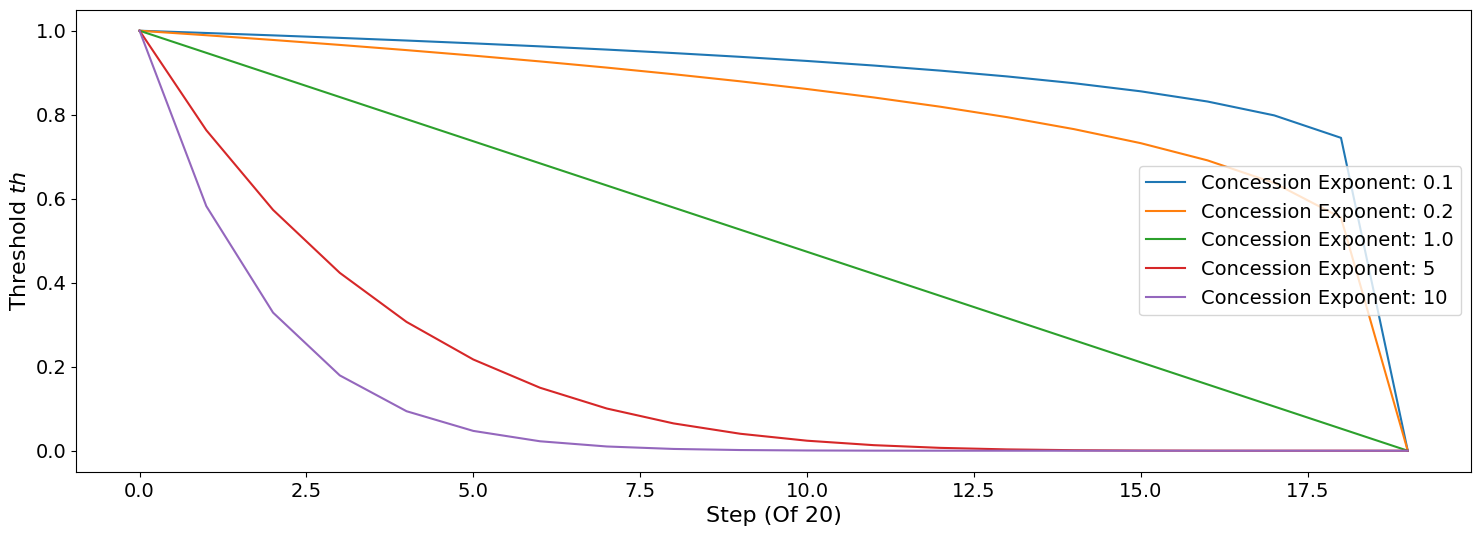

In [20]:
x = np.arange(20)
fig = plt.figure()
for e in [0.1, 0.2, 1.0, 5, 10]:
    a = BetterAgent(concession_exponent=e)
    y = [a._th(i, 20) for i in x]
    plt.plot(x, y, label=f"Concession Exponent: {e}")
    plt.xlabel("Step (Of 20)")
    plt.ylabel("Threshold $th$")
    plt.legend()

You can see that the smaller the exponent the more *hard-headed* will the agent be. Setting the concession exponent to $0$ will recover the behavior of the `SimpleAgent` in offering but will make it insisting on an unrealistic best price when responding to partner offers (can you see why?) which is definitely a bad idea. Setting it to $\inf$ will recover the behavior of `SimpleAgent` in responding to offers but will make its offers least favorable for itself in terms of price (can you see why?)

Given this threshold function, we can now define `is_good_price` and `_find_good_price`:

- ```_is_good_price``` simply compares the price given to it to the current threshold defined by multiplying ```th``` by the price range```mx - mn```
   - When selling this is achieved by comparing the difference between the price and minimum price to the curren threshold:
   
    ```python
    return (price - mn) >= th * (mx - mn)
    ```
    You can check that this will give the maximum unit price in the first step and gradually goes down to the minimum unit price in the last step (```n_steps - 1```)
   - When buying we go the other way around (starting at minimum price and going up over time to the maximum price):
   
   ```python
   return (mx - price) >= th * (mx - mn)
   ```
   
- ```_find_good_price``` works in the same fashion but rather than checking the goodness of a price, it simply uses the threshold to generate a ```good-enough``` price:

   ```python
   if self._is_selling(ami):
       return mn + th * (mx - mn)
   else:
       return mx - th * (mx - mn)
   ```
    
#### Why did not this approach work

As you may have noticed, `BetterAgent` is not relly better than `SimpleAgent`. why? The main reason is that price does not really matter that much in the settings for SCML 2024 OneShot because the price range is limited to only two consecutive values (e.g. (9, 10)) which increases the relative importance of avoiding penalties by matching demand and supply.

### Thinking about other negotiations

So far, our agent behaved **indepdendently** in each negotiation without considering what is happening in the others (except when one of them completes changing the amount `secured`). A simple way to consider other negotiations is to use the prices offered in them to limit our concessions. The following agent implements this idea
    

In [21]:
class AdaptiveAgent(BetterAgent):
    """Considers best price offers received when making its decisions"""

    def before_step(self):
        self._best_selling, self._best_buying = 0.0, float("inf")

    def respond(self, negotiator_id, state, source=""):
        """Save the best price received"""
        offer = state.current_offer
        response = super().respond(negotiator_id, state, source)
        nmi = self.get_nmi(negotiator_id)
        if self._is_selling(nmi):
            self._best_selling = max(offer[UNIT_PRICE], self._best_selling)
        else:
            self._best_buying = min(offer[UNIT_PRICE], self._best_buying)
        return response

    def _price_range(self, nmi):
        """Limits the price by the best price received"""
        mn, mx = super()._price_range(nmi)
        if self._is_selling(nmi):
            mn = max(mn, self._best_selling)
        else:
            mx = min(mx, self._best_buying)
        return mn, mx

Let's see how well did this agent behave:

In [22]:
single_agent_runner(AdaptiveAgent)
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
4,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
0,AdaptiveAgent,0.756491,30.0,0.756491,0.367015,0.064872,0.318639,0.897773,1.008595,1.181927
1,BetterAgent,0.742522,30.0,0.742522,0.355723,0.087694,0.320086,0.871921,0.978388,1.181927
2,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
3,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094


Not even as good as `BetterAgent`, at least in this simulation. One possiblity here is that the agent became too hard-headed again because now whenever it sees a good price on one negotiation, it insists on it for all the rest. This may not be a good idea sometimes as it may lead to more disagreements. In general *the agent must balance getting good prices with matching its input and output quantities*.

Let's just now see what happens if we are generous enough to grant our partner the best price for **them** half of the time. This should work because price is not important in SCML-OneShot

In [23]:
class GenerousAgent(SimpleAgent):
    """A greedy agent that always gives the best price for the opponent"""

    def _find_good_price(self, nmi):
        """Finds a good-enough price conceding linearly over time"""
        i = nmi.issues[UNIT_PRICE]
        return i.min_value if random.random() < 0.5 else i.max_value

In [24]:
single_agent_runner(GenerousAgent);

In [25]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
5,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
2,GenerousAgent,0.850194,30.0,0.850194,0.240858,0.260795,0.819196,0.886290,0.989907,1.171139
0,AdaptiveAgent,0.756491,30.0,0.756491,0.367015,0.064872,0.318639,0.897773,1.008595,1.181927
1,BetterAgent,0.742522,30.0,0.742522,0.355723,0.087694,0.320086,0.871921,0.978388,1.181927
3,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
4,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094


We finally *kind of* recover the performance of the `SimpleAgent`. That is how *unimportant* reasoning about prices is for SCML-OneShot. The situation changes dramatically in SCML-Std though as prices become more important.

### OneShotSyncAgent

One problem that plagued all of our agents so far is that they have to make decisions (`respond`, `propose`) about negotiations **on the spot**. This makes it difficult to consider **all other negotiations** while making decisions. 

Because the utility function is defined for **a complete set of negotiation agreements** and not for any single negotiation by itself, it makes sense to try to make decisions **centrally** by collecting offers from partners then responding to all of them at once. It is possible to do that by utilizing the response type ```ResponseType.WAIT``` supported by NegMAS but this entails a lot of house-keeping. 

To simplify this task, we provide another base class for agents that does all of this house keeping for you exposing a simple interface that **syncrhonizes** all negotiations (as much as allowed by the underlying platform). The main goal of this base agent is to allow the developer to think about *all negotiations together* but it has some important caveats which we will discuss later.
Here is an example of writing the do-nothing agent in this form:

In [26]:
class MySyncOneShotDoNothing(OneShotSyncAgent):
    """My Agent that does nothing"""

    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        return dict()

    def first_proposals(self):
        """Decide a first proposal on every negotiation.
        Returning None for a negotiation means ending it."""
        return dict()

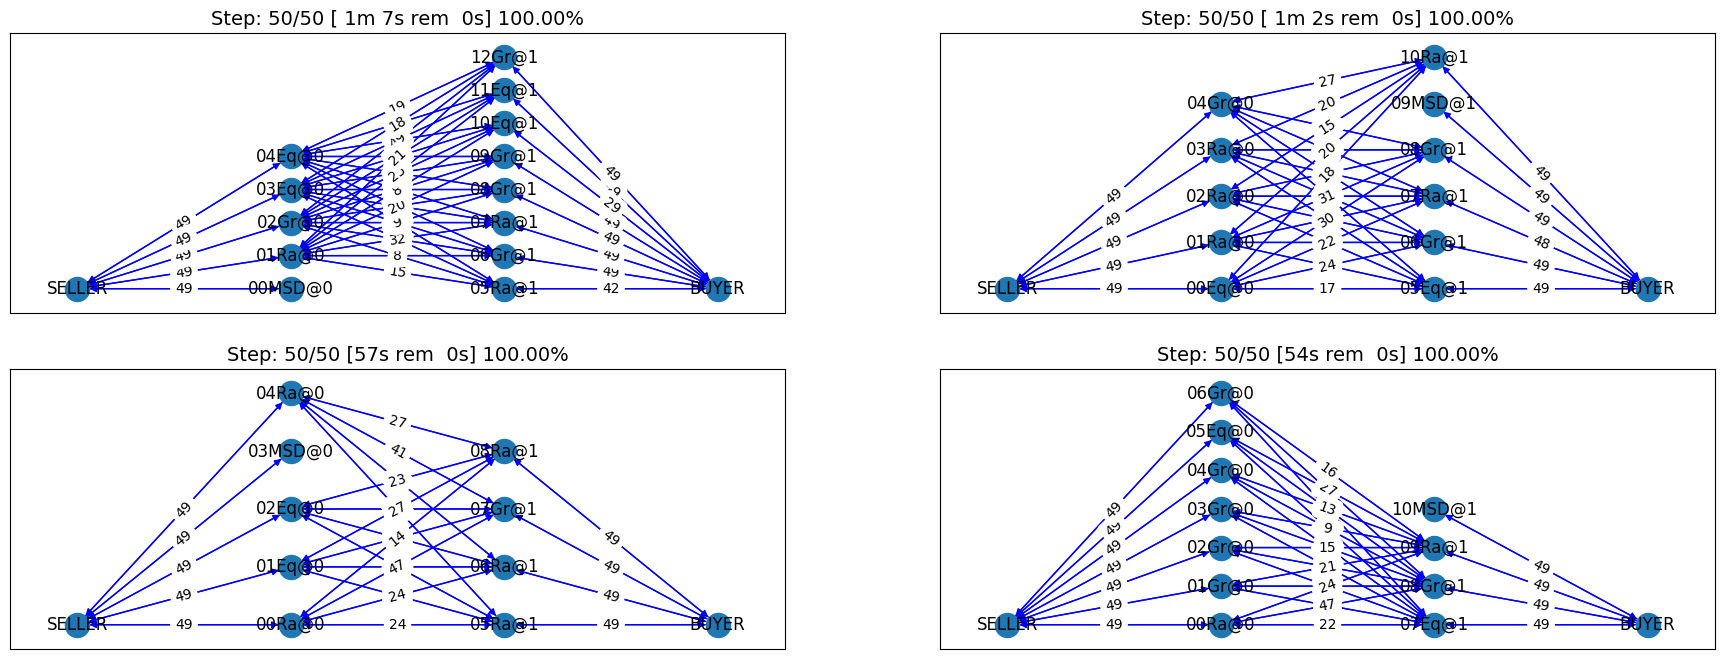

In [27]:
single_agent_runner(MySyncOneShotDoNothing)
single_agent_runner.draw_worlds_of(MySyncOneShotDoNothing);

As you can see, in this case, we need to override `counter_all` to counter offers received from *all* the partners and `first_proposals` to decide a first offer for *each* partner. 

Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `counter_all` and `first_proposals` are optional.

#### A not so-good SyncAgent

The main advantage of using the `OneShotSyncAgent` is that you do not need to keep track of state variables (like `secured`, `_supplies` and `_sales` used earlier) and you have a common place to make your decisions about **all** negotiations at the same time. Here is a simple greedy agent using this approach.

In [28]:
class NaiveSyncAgent(OneShotSyncAgent):
    """A greedy agent based on OneShotSyncAgent"""

    def __init__(self, *args, threshold=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self._threshold = threshold

    def before_step(self):
        super().before_step()
        self.ufun.find_limit(True)
        self.ufun.find_limit(False)

    def first_proposals(self):
        """Decide a first proposal on every negotiation.
        Returning None for a negotiation means ending it."""
        return dict(
            zip(
                self.negotiators.keys(),
                (self.best_offer(_) for _ in self.negotiators.keys()),
            )
        )

    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""

        # Initialize all responses by my best options
        responses = {
            k: SAOResponse(ResponseType.REJECT_OFFER, v)
            for k, v in self.first_proposals().items()
        }

        # find how much quantity do I still need
        my_needs = self._needed()

        # Am I a seller?
        is_selling = (self._is_selling(self.get_nmi(_)) for _ in offers.keys())

        # sort my offres by price (descendingly/ascendingly for a seller/buyer)
        sorted_offers = sorted(
            zip(offers.values(), is_selling),
            key=lambda x: (-x[0][UNIT_PRICE]) if x[1] else x[0][UNIT_PRICE],
        )

        # greedly choose offers until my needs are satsified
        secured, outputs, chosen = 0, [], dict()
        for i, k in enumerate(offers.keys()):
            offer, is_output = sorted_offers[i]
            secured += offer[QUANTITY]
            if secured >= my_needs:
                break
            chosen[k] = offer
            outputs.append(is_output)

        # calculate the utility of selected offers
        u = self.ufun.from_offers(tuple(chosen.values()), tuple(outputs))

        # if the utility of selected offers is high enough, accept them
        rng = self.ufun.max_utility - self.ufun.min_utility
        threshold = self._threshold * rng + self.ufun.min_utility
        if u >= threshold:
            for k, v in chosen.items():
                responses[k] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
        return responses

    def best_offer(self, negotiator_id):
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return None
        ami = self.get_nmi(negotiator_id)
        if not ami:
            return None
        quantity_issue = ami.issues[QUANTITY]

        offer = [-1] * 3
        offer[QUANTITY] = max(
            min(my_needs, quantity_issue.max_value), quantity_issue.min_value
        )
        offer[TIME] = self.awi.current_step
        offer[UNIT_PRICE] = self._find_good_price(ami)
        return tuple(offer)

    def is_seller(self, negotiator_id):
        return negotiator_id in self.awi.current_negotiation_details["sell"].keys()

    def _needed(self, negotiator_id=None):
        return (
            self.awi.needed_sales
            if self.is_seller(negotiator_id)
            else self.awi.needed_supplies
        )

    def _find_good_price(self, nmi):
        """Finds a good-enough price conceding linearly over time"""
        if self._is_selling(nmi):
            return nmi.issues[UNIT_PRICE].min_value
        return nmi.issues[UNIT_PRICE].max_value

    def _is_selling(self, ami):
        return ami.annotation["product"] == self.awi.my_output_product

This agent shows a case of parameterizing your agent so that it can be tested with different hyper-parameters. You do that by passing whatever parameters you like as keyword arguments to the constctor:

```python
def __init__(self, *args, threshold=0.3, **kwargs):
    super().__init__(*args, **kwargs)
    self._threshold = threshold
```

The one paramter we have is a threshold of utility relative to the maximum possile utility that we are willing to accept.

This agent also shows a case in which we use the built-in utility function implemented by the system (see [Section 2.3 of the game description](http://www.yasserm.com/scml/scml2021oneshot.pdf)). This ufun is accessible as `ufun`. By default the ufun will return the profit in dollars for a given set of negotiation outcomes, offers, agreements, or contracts. Note that the ufun assumes that what it is given *is the complete set of agreements and no others will be added to them later*. This value may be positive or negative (loss). In some cases you need to get the utility value normalized to a range between zero and one. This agent will do that. To do this normalization, we need to know the value of maximum and minimum utilities. You can of course solve the corresponding optimziation problem but we did that for you. All you need is call `find_limit` and pass it a boolean (`True` for calculating the highest possible utility and `False` for calculating the lowest possible utility). To avoid doing this calculation repeatedly, you should store the results in `ufun.best` or `ufun.worst` for highest and lowest utility. After that, you can access the maximum possible utility as `max_utility` and minimum possible utility as `min_utility`. We do that in the `before_step()` method (called at the beginning of every day):

```python
 def before_step(self):
    super().init()
    self.ufun.find_limit(True)
    self.ufun.find_limit(False)
```

After this call, we can access `maximum_utility`, `minimum_utility`, `best`, `worst` members of the ufun. As explained earlier, `best` and `worst` give extra information about the conditions for achieving maximum and minimum utility.

We need to implement two methods: `first_proposals` (to generate a good first proposal for each negotiation) and `counter_all` (for countering a set of offers). We inherit from `SimpleAgent` in order to get access to `best_offer` and `_is_selling` methods (we could have repeated them here again of course. Note that, because of the way inheritence works in python, we must inherit from `OneShotSyncAgent` before `SimpleAgent`.

The first set of proposals in `first_proposals` is simply the `best_offer` for each negotiation which is calculated using this generator expression:
```python
(self.best_offer(_) for _ in self.negotiators.keys())
```


Almost all the code now resides in the `counter_all` method. We will go over it here:

- We start by initializing our response by the best offer for each negotiation using `first_proposals` and calculating our needs using `_needed`
```python
responses = {
    k: SAOResponse(ResponseType.REJECT_OFFER, _) 
    for k, v in self.first_proposals().items()
}
my_needs = self._needed(None)
```

- We then sort the offers so that earlier offers have *better* prices for us. For sell offers, this means descendingly and for buy offers ascendingly.
```python
is_selling = ( self._is_selling(self.get_nmi(_)) for _ in offers.keys() )
sorted_offers = sorted(
    zip(offers.values(), is_selling), 
    key=lambda x: (- x[0][UNIT_PRICE]) if x[1] else x[0][UNIT_PRICE]
)
```
- We *greedily* find a set of offers that satisfy all our needs (or as much as possible from them). 
```python
secured, outputs, chosen = 0, [], dict()
for i, k in enumerate(offers.keys()):
    offer, is_output = sorted_offers[i]
    secured += offer[QUANTITY]
    if secured >= my_needs:
        break
    chosen[k] = offer
    outputs.append(is_output)
```
- Finally, we calculate the utility of accepting these *and only these* offers and accept the chosen offers if they provide 70% of the maximum possible utility. Otherwise, we reject all offers sending the default `best_offer` value back.
```python
u = self.ufun.from_offers(tuple(chosen.values()), tuple(outputs))
rng = self.ufun.max_utility - self.ufun.min_utility
threshold = self._threshold * rng + self.ufun.min_utility
if u >= threshold:
    for k, v in chosen.items():
        responses[k] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
return responses
```

Let's see how did it do:

In [29]:
single_agent_runner(NaiveSyncAgent)
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
7,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
2,GenerousAgent,0.850194,30.0,0.850194,0.240858,0.260795,0.819196,0.886290,0.989907,1.171139
0,AdaptiveAgent,0.756491,30.0,0.756491,0.367015,0.064872,0.318639,0.897773,1.008595,1.181927
1,BetterAgent,0.742522,30.0,0.742522,0.355723,0.087694,0.320086,0.871921,0.978388,1.181927
4,MySyncOneShotDoNothing,0.717437,30.0,0.717437,0.128590,0.518223,0.587364,0.712251,0.853799,0.885967
3,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
6,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094
5,NaiveSyncAgent,0.578200,30.0,0.578200,0.288741,0.087481,0.308480,0.600469,0.810890,1.034915


Ok it works but you did not expect it to work well. right? We called it `Naive` for a reason.

This base-class simplifies the job of the agent developer by providing a single function (`counter_all`) in which to handle all offers it receive (most of the time, remember that sometimes you will receive a subset of the offers in the call). In principle the agent can then decide to accept a few of these offers and keep negotiating. 

The problem with this agent is that it defines a **good offer** independently for each negotiation which defeats the purpose of having the chance to decide centrally what to do for all negotiations. That is made even less effective by the fact that in SCML 2024, price does not matter that much. In the following section, we design a very simple alternative that tries to resolve this issue

### A better SyncAgent

We start by defining a simple helper function that distributes a given quantity $q$ over $n$ partners.

In [30]:
def distribute(q: int, n: int) -> list[int]:
    """Distributes n values over m bins with at
    least one item per bin assuming q > n"""
    from numpy.random import choice
    from collections import Counter

    if q < n:
        lst = [0] * (n - q) + [1] * q
        random.shuffle(lst)
        return lst

    if q == n:
        return [1] * n
    r = Counter(choice(n, q - n))
    return [r.get(_, 0) + 1 for _ in range(n)]

Here are few examples of how it would distribute $10$ units over $4$ partners

In [31]:
[distribute(10, 4) for _ in range(5)]

[[3, 2, 2, 3], [2, 2, 4, 2], [3, 3, 2, 2], [2, 4, 2, 2], [1, 3, 2, 4]]

In [32]:
[distribute(2, 4) for _ in range(5)]

[[1, 0, 0, 1], [1, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 0]]

We will also need a helper function to find all subsets of a given set (powerset):

In [33]:
from itertools import chain, combinations


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

In [34]:
class BetterSyncAgent(OneShotSyncAgent):
    """An agent that distributes its needs over its partners randomly."""

    def distribute_needs(self) -> dict[str, int]:
        """Distributes my needs randomly over all my partners"""

        dist = dict()
        for needs, all_partners in [
            (self.awi.needed_supplies, self.awi.my_suppliers),
            (self.awi.needed_sales, self.awi.my_consumers),
        ]:
            # find suppliers and consumers still negotiating with me
            partner_ids = [_ for _ in all_partners if _ in self.negotiators.keys()]
            partners = len(partner_ids)

            # if I need nothing, end all negotiations
            if needs <= 0:
                dist.update(dict(zip(partner_ids, [0] * partners)))
                continue

            # distribute my needs over my (remaining) partners.
            dist.update(dict(zip(partner_ids, distribute(needs, partners))))
        return dist

    def first_proposals(self):
        # just randomly distribute my needs over my partners (with best price for me).
        s, p = self._step_and_price(best_price=True)
        distribution = self.distribute_needs()
        d = {k: (q, s, p) if q > 0 else None for k, q in distribution.items()}
        return d

    def counter_all(self, offers, states):
        response = dict()
        # process for sales and supplies independently
        for needs, all_partners, issues in [
            (
                self.awi.needed_supplies,
                self.awi.my_suppliers,
                self.awi.current_input_issues,
            ),
            (
                self.awi.needed_sales,
                self.awi.my_consumers,
                self.awi.current_output_issues,
            ),
        ]:
            # get a random price
            price = issues[UNIT_PRICE].rand()
            # find active partners
            partners = {_ for _ in all_partners if _ in offers.keys()}

            # find the set of partners that gave me the best offer set
            # (i.e. total quantity nearest to my needs)
            plist = list(powerset(partners))
            best_diff, best_indx = float("inf"), -1
            for i, partner_ids in enumerate(plist):
                others = partners.difference(partner_ids)
                offered = sum(offers[p][QUANTITY] for p in partner_ids)
                diff = abs(offered - needs)
                if diff < best_diff:
                    best_diff, best_indx = diff, i
                if diff == 0:
                    break

            # If the best combination of offers is good enough, accept them and end all
            # other negotiations
            th = self._current_threshold(
                min([_.relative_time for _ in states.values()])
            )
            if best_diff <= th:
                partner_ids = plist[best_indx]
                others = list(partners.difference(partner_ids))
                response |= {
                    k: SAOResponse(ResponseType.ACCEPT_OFFER, offers[k])
                    for k in partner_ids
                } | {k: SAOResponse(ResponseType.END_NEGOTIATION, None) for k in others}
                continue

            # If I still do not have a good enough offer, distribute my current needs
            # randomly over my partners.
            distribution = self.distribute_needs()
            response.update(
                {
                    k: SAOResponse(ResponseType.END_NEGOTIATION, None)
                    if q == 0
                    else SAOResponse(
                        ResponseType.REJECT_OFFER, (q, self.awi.current_step, price)
                    )
                    for k, q in distribution.items()
                }
            )
        return response

    def _current_threshold(self, r: float):
        mn, mx = 0, self.awi.n_lines // 2
        return mn + (mx - mn) * (r**4.0)

    def _step_and_price(self, best_price=False):
        """Returns current step and a random (or max) price"""
        s = self.awi.current_step
        seller = self.awi.is_first_level
        issues = (
            self.awi.current_output_issues if seller else self.awi.current_input_issues
        )
        pmin = issues[UNIT_PRICE].min_value
        pmax = issues[UNIT_PRICE].max_value
        if best_price:
            return s, pmax if seller else pmin
        return s, random.randint(pmin, pmax)

In [35]:
single_agent_runner(BetterSyncAgent)
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
2,BetterSyncAgent,1.045027,30.0,1.045027,0.058560,0.954717,1.003720,1.039322,1.076773,1.155156
8,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
3,GenerousAgent,0.850194,30.0,0.850194,0.240858,0.260795,0.819196,0.886290,0.989907,1.171139
0,AdaptiveAgent,0.756491,30.0,0.756491,0.367015,0.064872,0.318639,0.897773,1.008595,1.181927
1,BetterAgent,0.742522,30.0,0.742522,0.355723,0.087694,0.320086,0.871921,0.978388,1.181927
5,MySyncOneShotDoNothing,0.717437,30.0,0.717437,0.128590,0.518223,0.587364,0.712251,0.853799,0.885967
4,MyOneShotDoNothing,0.716924,30.0,0.716924,0.128240,0.518197,0.587324,0.711476,0.852739,0.885616
7,RandomOneShotAgent,0.657930,30.0,0.657930,0.185348,0.336662,0.517957,0.717340,0.780287,0.954094
6,NaiveSyncAgent,0.578200,30.0,0.578200,0.288741,0.087481,0.308480,0.600469,0.810890,1.034915


This is *almost* the highest score we got so far even though that agent is not that intelligent in its decision making. It is roughly on-bar with our `SimpleAgent`. Let's check it in details:

The main idea is to generate offers that will (assuming all accepted) give us all the quantity we need (to buy/sell). Moreover, we accept a set of offers if the total quantity they provide is within some small margin from the quantity we need.

#### helpers
We have a helper helper function (`_step_and_price`) to return the current step and either the best or a good-enough price. 

The core computation of the agent is implemented in the `distribute_needs()` method which is responsible of calculating a quantity for each partner (notice that price is completely ignored here).

We treat suppliers and consumers independently here by looping twice once for each:

```python
for needs, all_partners in [
    (self.awi.needed_supplies, self.awi.my_suppliers),
    (self.awi.needed_sales, self.awi.my_consumers),
]:
    ...
```

The process for ditributing my needs is straight forward:

1. find suppliers and consumers still negotiating with me
    ```python
    partner_ids = [_ for _ in all_partners if _ in self.negotiators.keys()]
    partners = len(partner_ids)            
    ```
2. if I need nothing, end all negotiations
   ```python
   if needs <= 0:
        dist.update(dict(zip(partner_ids, [0] * partners)))
        continue
   ```
3. otherwise, distribute my needs randomly using the `distribute` function defined earler:
   ```python
   dist.update(dict(zip(partner_ids, distribute(needs, partners))))
    ```
          
Now we can move the main part of the agent which consists of the two abstract method implementations (`first_proposals` and `counter_all`).

#### First set of offers

The first set of proposals from the agent use the best price and will distribute the total quantity needed randomly between all partners:
```python
s, p = self._step_and_price(best_price=True)
distribution = self.distribute_needs()    
```

We then just return the quantity for each partner or `None` to end the negotiation if the quantity was $0$
```python
return dict((k, (q, s, p) if q > 0 else None)  for k, q in distribution.items())
```

#### Countering offers

When receiving offers, we again treat suppliers and consumers independelty:

```python
for needs, all_partners, issues in [
   (
       self.awi.needed_supplies,
       self.awi.my_suppliers,
       self.awi.current_input_issues,
   ),
   (
       self.awi.needed_sales,
       self.awi.my_consumers,
       self.awi.current_output_issues,
   ),

]:
    ...
```

By treating our suppliers and consumers independetly, our agent can work -- in principle -- even if it finds itself in the middle of a deep supply chain (i.e. more than two production levels as in SCML-Std). Strictly speaking, this is not necessary for SCML-OneShot but it is a form of future-proofing that we get at a small cost.

When we receive some offers (in `counter_all`) we start by finding the subset of them (together) that best satisfy our needs up to a predefined threshold (defaulting to zero)

```python
plist = list(powerset(partners))
best_diff, best_indx = float("inf"), -1
for i, partner_ids in enumerate(plist):
    others = partners.difference(partner_ids)
    offered = sum(offers[p][QUANTITY] for p in partner_ids)
    diff = abs(offered - needs)
    if diff < best_diff:
        best_diff, best_indx = diff, i
    if diff == 0:
        break
```

If the best subset satisfies our needs up to a threshold (set as zero by default), we simply accept all of them ending all other negotiations:

```python
th = self._current_threshold(min([_.relative_time  for _ in states.values()]))
if best_diff <= th:
    partner_ids = plist[best_indx]
    others = list(partners.difference(partner_ids))
    response |= ({
        k: SAOResponse(ResponseType.ACCEPT_OFFER, offers[k]) for k in partner_ids
    } | {k: SAOResponse(ResponseType.END_NEGOTIATION, None) for k in others})
    continue
```

*Note that we could slightly improve that by only rejecting the remaining offers and offering whatever we still need to buy/sell to them when the threshold is nonezero and the best subset has a total quantity less than our needs. This may improve our results slightly but will complicate the code so we do not pursue it in this tutorial.*

If the best subset does not satisfy our needs up to the predefined threshold, we simply ignore all offers and generate a new random offer for our partners:

```python
distribution = self.distribute_needs()
return {
    k: SAOResponse(ResponseType.END_NEGOTIATION, None)
    if q == 0
    else SAOResponse(ResponseType.REJECT_OFFER, (q, s, p))
    for k, q in distribution.items()
}
```    

*Note that we simply end the negotiation with some partners (selected randomly) if our needs are less than the number of our partners (see `distribute_needs()`.*

#### Possible Improvements

There are obvious ways to improve this agent:

1. When countering offers, we should take into account the history of negotiation with each partner (in this round and previously) to make a more meaningful distribution of quantities over partners. Currently this is just random. We should also consider the probability that our offers will be accepted when deciding how to distribute the quantity we still need over our partners.
1. Choosing which negotiators to end the negotiation with when we need a small quantity to buy/sell, is currently random. We could try to find a way to only end negotiation with negotiators least likely to provide us with our remaining needs.
1. As indicated earlier, we should not just end the negotiation with all unselected partners when we accept some subset of the offers if the threshold was nonzero and the total quantity we are accepting is not enough to satisfy our needs.
1. We should take the number of rounds remiaining in the negotiation when deciding whether to accept a subset of offers (e.g. have a higher threshold near the end of the negotiation), and when deciding what quantities to distribute over our partners (e.g. offer more than what we need near the end of the negotiation under the assumption that only some of them will be accepted).
1. May be consider prices more when approaching our total needs.


### Comparing all agents

We can now summarize the results of comparing all agents developed so far and while we are at it, compare them with three built-in agents in the scml package:

In [36]:
for t in (RandDistOneShotAgent, EqualDistOneShotAgent, GreedySyncAgent):
    single_agent_runner(t)

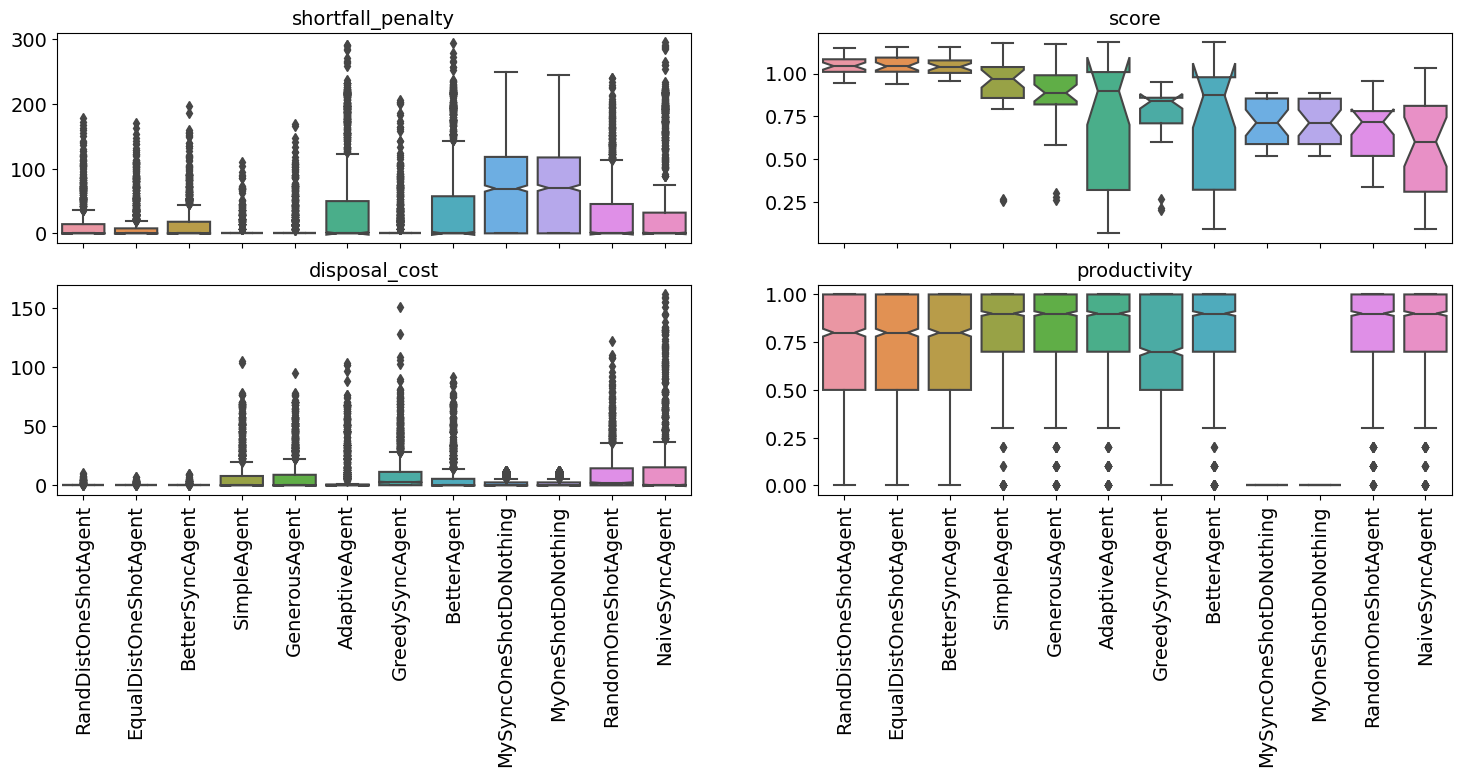

In [37]:
single_agent_runner.plot_stats(notch=True);

or in more details:

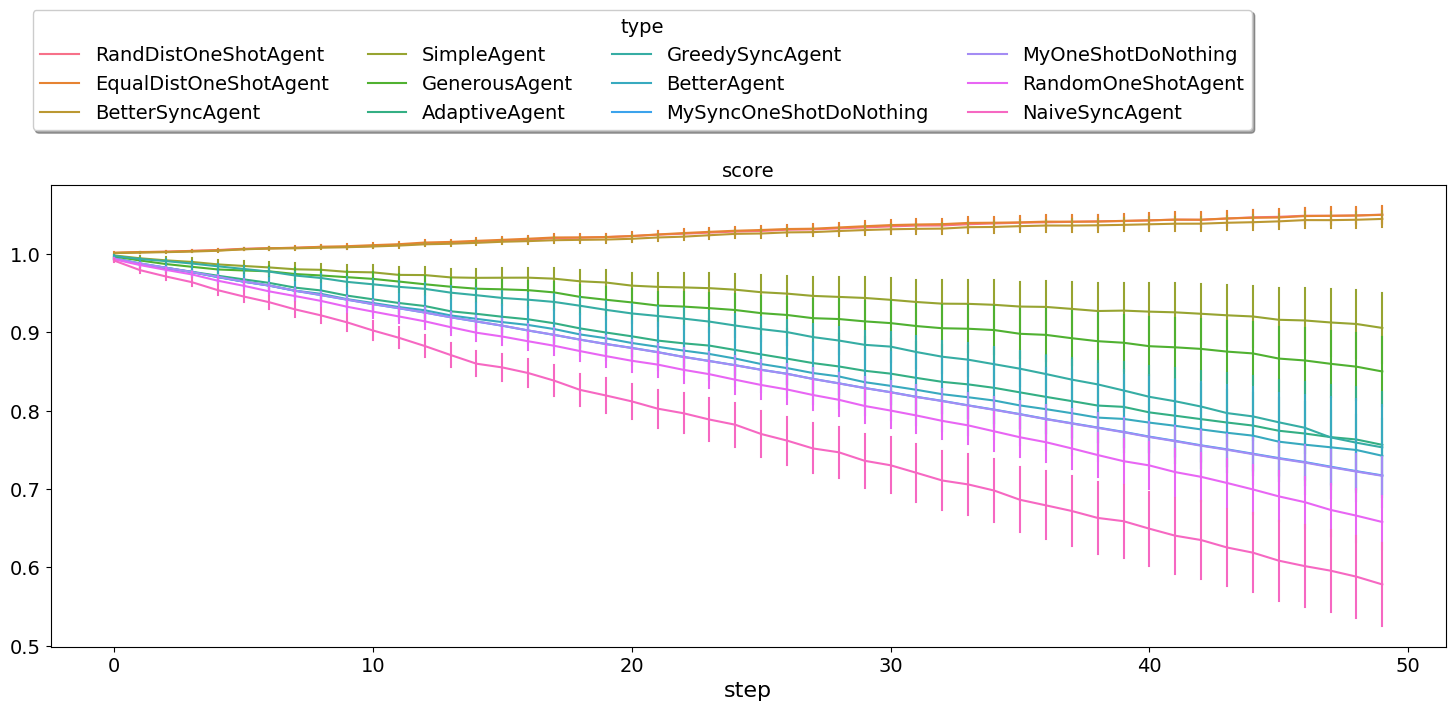

In [38]:
single_agent_runner.plot_stats(agg=False, stats="score", legend_ncols=4, ylegend=1.4);

You can easily notice that our SimpleAgent is actually hard to beat. No built-in agents can actually beat it. The one that comes closes is [`RandDistOneShotAgent`](https://scml.readthedocs.io/en/latest/autoapi/scml/oneshot/agents/rand/index.html#scml.oneshot.agents.rand.RandDistOneShotAgent).

The way we just compared these agents is  unbiased because all agents are allowed to control the same factories in the same simulation envoironment. Nevertheless, it is not the exact method used in the ANAC competition. The best way to compare these agents is to run a tournament between them. You already learned how to do that in the previous tutorial and we will not repeate it here.

*If you are running this notebook, please note that the tournament running methods `anac2024_*` may not work within a notebook environment. You can just move your code to a normal python script and it will run correctly*

Just out of curiousity, let's see how do these agents compare against each other if they are allowed to control the whole market instead of a single agent:

In [39]:
full_market_runner = WorldRunner.from_runner(
    single_agent_runner, control_all_agents=True
)
for a in (
    BetterSyncAgent,
    SimpleAgent,
    GenerousAgent,
    BetterAgent,
    AdaptiveAgent,
    MyOneShotDoNothing,
    MySyncOneShotDoNothing,
    NaiveSyncAgent,
    RandDistOneShotAgent,
    EqualDistOneShotAgent,
    GreedySyncAgent,
):
    full_market_runner(a)

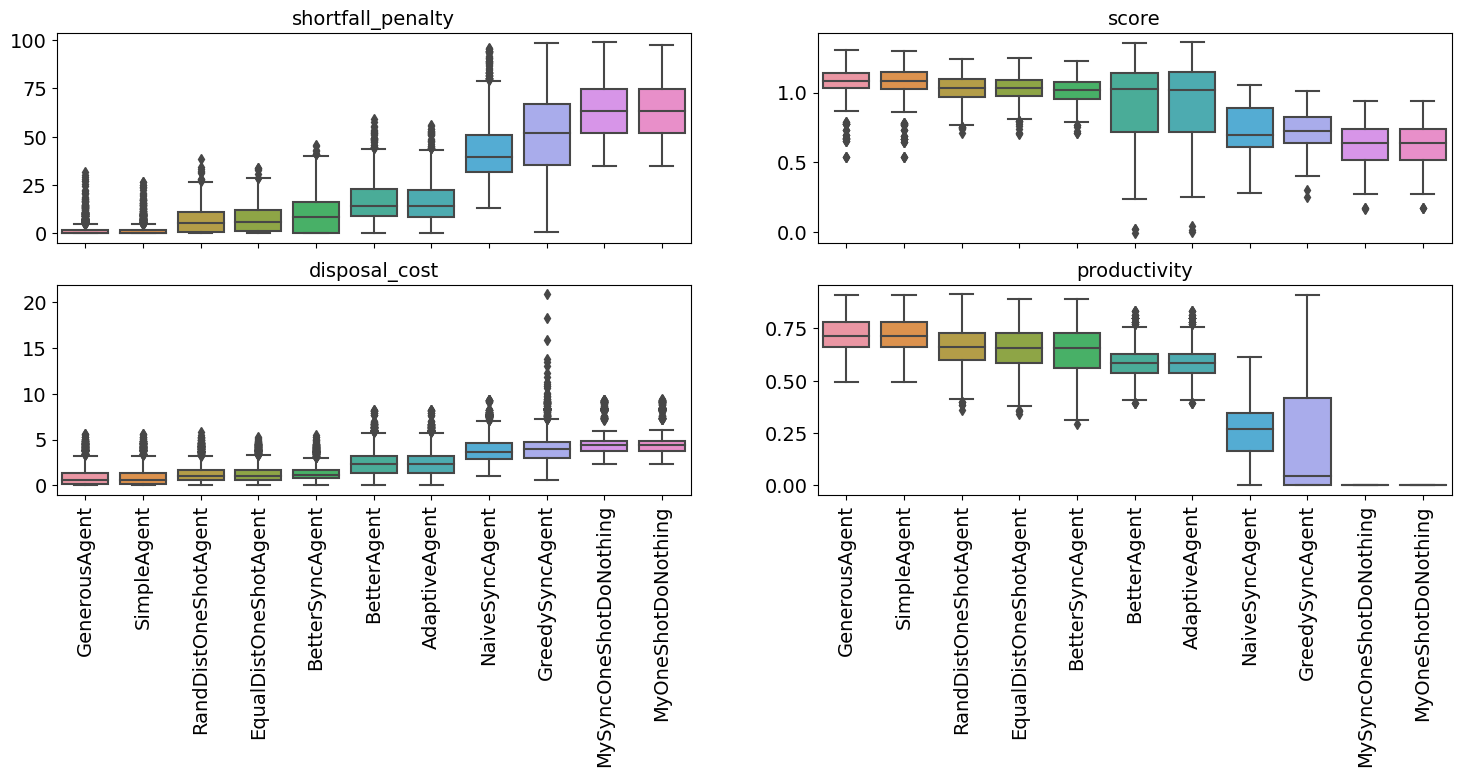

In [40]:
full_market_runner.plot_stats();

In [41]:
full_market_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
4,GenerousAgent,1.070493,345.0,1.070493,0.135989,0.536034,1.032085,1.085166,1.142087,1.300736
10,SimpleAgent,1.068242,345.0,1.068242,0.139472,0.536031,1.028666,1.080434,1.147335,1.294385
9,RandDistOneShotAgent,1.027933,345.0,1.027933,0.093962,0.712678,0.965100,1.032097,1.100143,1.242283
3,EqualDistOneShotAgent,1.024942,345.0,1.024942,0.096280,0.706985,0.975430,1.034344,1.090284,1.249036
2,BetterSyncAgent,1.008757,345.0,1.008757,0.091677,0.710329,0.952090,1.021285,1.072802,1.228448
1,BetterAgent,0.931797,345.0,0.931797,0.264753,-0.006554,0.720905,1.023227,1.139277,1.353749
0,AdaptiveAgent,0.931182,345.0,0.931182,0.267260,0.002970,0.721272,1.015031,1.145970,1.358184
8,NaiveSyncAgent,0.737871,345.0,0.737871,0.181944,0.282766,0.608280,0.696524,0.886265,1.053605
5,GreedySyncAgent,0.726222,345.0,0.726222,0.128911,0.251198,0.642664,0.723267,0.824934,1.008826
7,MySyncOneShotDoNothing,0.628966,345.0,0.628966,0.156728,0.170207,0.516510,0.637839,0.740412,0.941539


You can find all the agents available in the `scml` package for the one-shot game under `scml.oneshot.agents` including the ones developed in this tutorial (with some modifications):

In [42]:
import scml.oneshot.agents as agents

print([_ for _ in agents.__dir__() if _.endswith("Agent")])

[
    'SingleAgreementAspirationAgent',
    'GreedyOneShotAgent',
    'GreedySyncAgent',
    'GreedySingleAgreementAgent',
    'OneshotDoNothingAgent',
    'RandomOneShotAgent',
    'RandDistOneShotAgent',
    'EqualDistOneShotAgent',
    'SyncRandomOneShotAgent',
    'SingleAgreementRandomAgent'
]

## Running against winners from previous years

You can compare your agent against any agents previously submitted to SCML (same track). To do that, you need to install the `scml-agents` package from pip:\

> pip install scml-agents

You can then get agents using the `get_agents()` function from this package:

In [43]:
from scml_agents import get_agents

winners = [
    get_agents(y, track="oneshot", winners_only=True, as_class=True)[0]
    for y in (2021, 2022, 2023)
]
print(winners)

[
    <class 'scml_agents.scml2021.oneshot.team_86.agent112.Agent112'>,
    <class 'scml_agents.scml2022.oneshot.team_134.agent119.PatientAgent'>,
    <class 'scml_agents.scml2023.oneshot.team_poli_usp.quantity_oriented_agent.QuantityOrientedAgent'>
]

Let's add them to the mix

In [44]:
for t in winners:
    single_agent_runner(t)

In [45]:
single_agent_runner.score_summary()

,type,score,count,mean,std,min,25%,50%,75%,max
12,RandDistOneShotAgent,1.050543,30.0,1.050543,0.056464,0.943806,1.009891,1.043736,1.083475,1.149113
4,EqualDistOneShotAgent,1.050253,30.0,1.050253,0.063765,0.941294,1.010509,1.041863,1.093314,1.157501
3,BetterSyncAgent,1.045027,30.0,1.045027,0.058560,0.954717,1.003720,1.039322,1.076773,1.155156
11,QuantityOrientedAgent,0.991510,30.0,0.991510,0.137315,0.635187,0.942474,1.033218,1.056788,1.175083
10,PatientAgent,0.909359,30.0,0.909359,0.237183,0.306590,0.832855,0.951183,1.062123,1.181927
14,SimpleAgent,0.905806,30.0,0.905806,0.243713,0.256752,0.857049,0.969827,1.038091,1.176166
5,GenerousAgent,0.850194,30.0,0.850194,0.240858,0.260795,0.819196,0.886290,0.989907,1.171139
0,AdaptiveAgent,0.756491,30.0,0.756491,0.367015,0.064872,0.318639,0.897773,1.008595,1.181927
6,GreedySyncAgent,0.753260,30.0,0.753260,0.198388,0.198635,0.708680,0.837813,0.858390,0.951864
1,Agent112,0.742568,30.0,0.742568,0.358775,0.065792,0.334495,0.870720,1.025299,1.181927


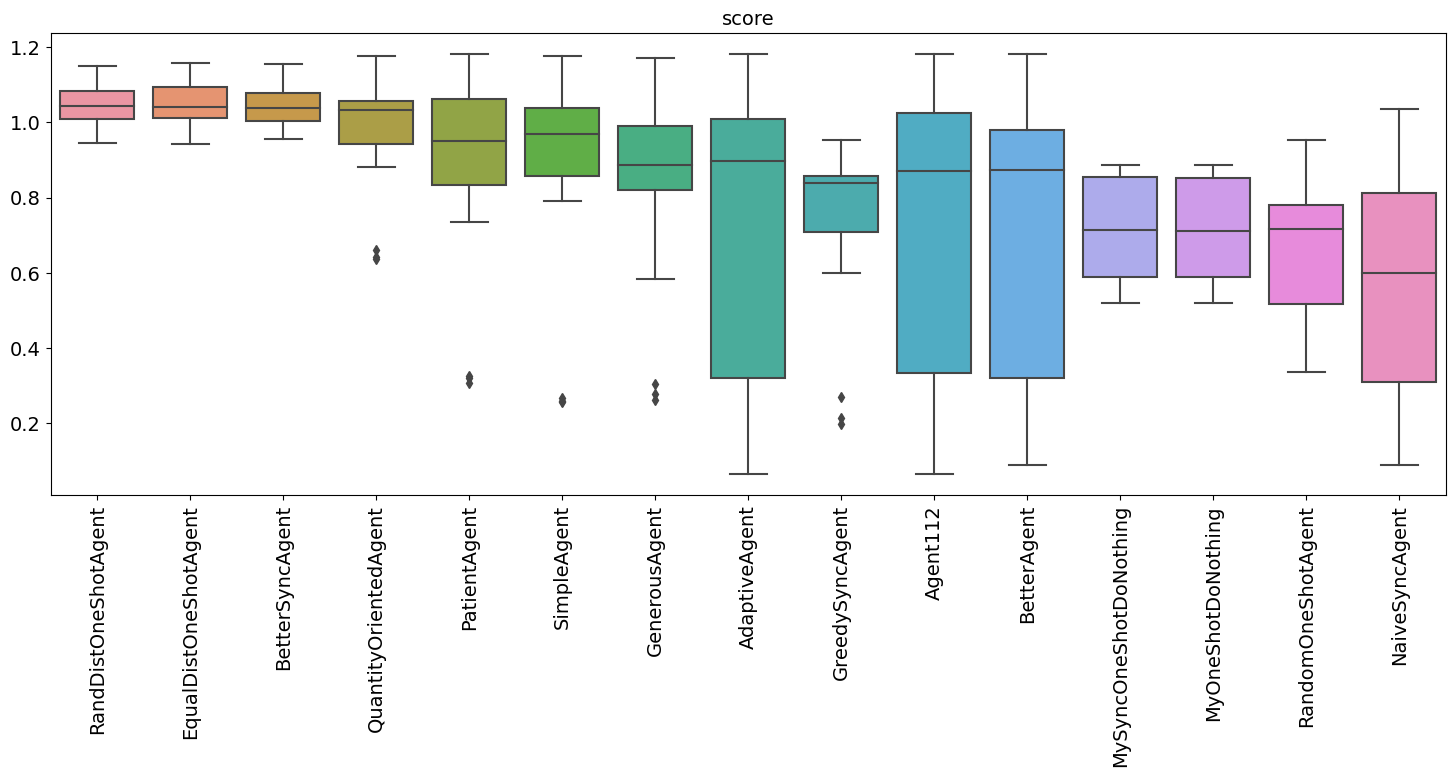

In [46]:
single_agent_runner.plot_stats(stats="score");

`QuantityOrientedAgent`, the winner of SCML 2023 OneShot is the best performing agent followed by `PatientAgent` winner of the SCML 2022 OneShot competition. Nevertheless, the differences between these agens and our `SimpleAgent` Can you beat them?
The next tutorial explains how to try to achieve that using Reinforcement Learning but now you have enough information to build your own agent for SCML OneShot. Happy hacking